# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

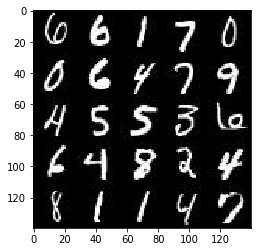

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

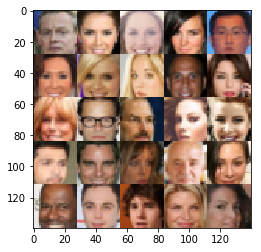

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    learning_rate = tf.placeholder(dtype = tf.float32)
    image_input = tf.placeholder(dtype = tf.float32, shape=(None, image_height, image_width, image_channels), name="image")
    z_input = tf.placeholder(dtype = tf.float32, shape=(None, z_dim), name="z_input")
    return image_input, z_input, learning_rate

tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training = True)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.reshape(x2, shape=(-1, 7*7*128))
        x3 = tf.layers.dense(x3, 7*7*128)
        
        logits = tf.layers.dense(x3, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        x0 = tf.layers.dense(z, 7*7*128)
        x0 = tf.reshape(x0, shape=(-1, 7, 7, 128))
        
        x1 = tf.layers.conv2d_transpose(x0, 64, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, out_channel_dim, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.maximum(alpha*x2, x2)

    return x2

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    alpha = 0.01
    g_model_output = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_fake_output, d_fake_logit = discriminator(g_model_output, alpha=alpha, reuse=False)
    d_real_output, d_real_logit = discriminator(input_real, alpha=alpha, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logit, labels=tf.ones_like(d_real_output)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.zeros_like(d_fake_output)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.ones_like(d_fake_output)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [72]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [73]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [78]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    show_every = 100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers,
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % show_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),\
                          "Batch {}...".format(steps),\
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),\
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % 500 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Batch 10... Discriminator Loss: 0.0000... Generator Loss: 17.6967
Epoch 1/10... Batch 20... Discriminator Loss: 0.0000... Generator Loss: 84.5639
Epoch 1/10... Batch 30... Discriminator Loss: 0.0000... Generator Loss: 66.3115
Epoch 1/10... Batch 40... Discriminator Loss: 0.0000... Generator Loss: 40.8955
Epoch 1/10... Batch 50... Discriminator Loss: 196.6034... Generator Loss: 1453.7314
Epoch 1/10... Batch 60... Discriminator Loss: 225.5415... Generator Loss: 171.3430
Epoch 1/10... Batch 70... Discriminator Loss: 0.0000... Generator Loss: 783.9185
Epoch 1/10... Batch 80... Discriminator Loss: 0.0293... Generator Loss: 516.7308
Epoch 1/10... Batch 90... Discriminator Loss: 295.8417... Generator Loss: 3.1349
Epoch 1/10... Batch 100... Discriminator Loss: 0.0000... Generator Loss: 426.1736


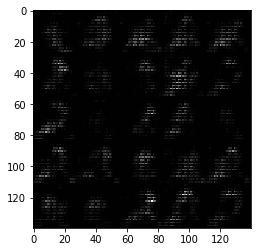

Epoch 1/10... Batch 110... Discriminator Loss: 0.0000... Generator Loss: 321.9015
Epoch 1/10... Batch 120... Discriminator Loss: 0.0000... Generator Loss: 234.9196
Epoch 1/10... Batch 130... Discriminator Loss: 0.0000... Generator Loss: 175.1490
Epoch 1/10... Batch 140... Discriminator Loss: 0.0000... Generator Loss: 110.7769
Epoch 1/10... Batch 150... Discriminator Loss: 0.0006... Generator Loss: 73.8177
Epoch 1/10... Batch 160... Discriminator Loss: 0.0000... Generator Loss: 115.5771
Epoch 1/10... Batch 170... Discriminator Loss: 0.0000... Generator Loss: 169.4914
Epoch 1/10... Batch 180... Discriminator Loss: 0.0000... Generator Loss: 151.1318
Epoch 1/10... Batch 190... Discriminator Loss: 2.3270... Generator Loss: 53.2926
Epoch 1/10... Batch 200... Discriminator Loss: 25.7332... Generator Loss: 18.1481


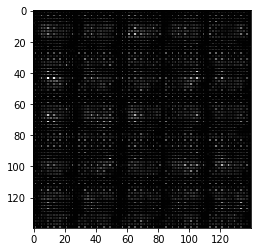

Epoch 1/10... Batch 210... Discriminator Loss: 0.0000... Generator Loss: 579.4774
Epoch 1/10... Batch 220... Discriminator Loss: 0.0000... Generator Loss: 318.7037
Epoch 1/10... Batch 230... Discriminator Loss: 0.0003... Generator Loss: 57.7101
Epoch 1/10... Batch 240... Discriminator Loss: 0.1418... Generator Loss: 43.7088
Epoch 1/10... Batch 250... Discriminator Loss: 0.0002... Generator Loss: 65.3982
Epoch 1/10... Batch 260... Discriminator Loss: 0.0000... Generator Loss: 145.7198
Epoch 1/10... Batch 270... Discriminator Loss: 0.0000... Generator Loss: 128.0392
Epoch 1/10... Batch 280... Discriminator Loss: 0.0000... Generator Loss: 133.4633
Epoch 1/10... Batch 290... Discriminator Loss: 0.0000... Generator Loss: 122.7493
Epoch 1/10... Batch 300... Discriminator Loss: 2.2463... Generator Loss: 24.5268


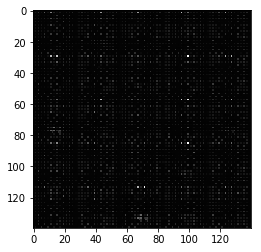

Epoch 1/10... Batch 310... Discriminator Loss: 0.0000... Generator Loss: 179.0853
Epoch 1/10... Batch 320... Discriminator Loss: 0.0000... Generator Loss: 111.7560
Epoch 1/10... Batch 330... Discriminator Loss: 0.0000... Generator Loss: 228.2272
Epoch 1/10... Batch 340... Discriminator Loss: 0.0000... Generator Loss: 144.1103
Epoch 1/10... Batch 350... Discriminator Loss: 0.0000... Generator Loss: 95.7503
Epoch 1/10... Batch 360... Discriminator Loss: 0.0000... Generator Loss: 122.5108
Epoch 1/10... Batch 370... Discriminator Loss: 0.0002... Generator Loss: 35.2549
Epoch 1/10... Batch 380... Discriminator Loss: 0.0000... Generator Loss: 29.7463
Epoch 1/10... Batch 390... Discriminator Loss: 0.0000... Generator Loss: 26.9928
Epoch 1/10... Batch 400... Discriminator Loss: 0.0008... Generator Loss: 20.7933


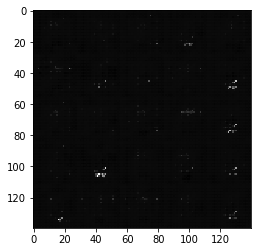

Epoch 1/10... Batch 410... Discriminator Loss: 0.0000... Generator Loss: 24.0270
Epoch 1/10... Batch 420... Discriminator Loss: 0.0000... Generator Loss: 22.8890
Epoch 1/10... Batch 430... Discriminator Loss: 0.0002... Generator Loss: 24.7271
Epoch 1/10... Batch 440... Discriminator Loss: 0.0118... Generator Loss: 26.5701
Epoch 1/10... Batch 450... Discriminator Loss: 0.0000... Generator Loss: 50.9730
Epoch 1/10... Batch 460... Discriminator Loss: 0.0000... Generator Loss: 91.8896
Epoch 2/10... Batch 470... Discriminator Loss: 0.0000... Generator Loss: 78.2850
Epoch 2/10... Batch 480... Discriminator Loss: 0.0964... Generator Loss: 72.6221
Epoch 2/10... Batch 490... Discriminator Loss: 0.0000... Generator Loss: 70.1784
Epoch 2/10... Batch 500... Discriminator Loss: 0.0000... Generator Loss: 60.5137


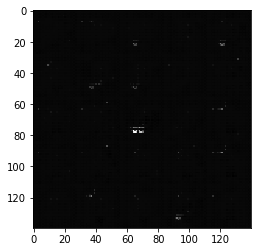

Epoch 2/10... Batch 510... Discriminator Loss: 0.0000... Generator Loss: 59.0515
Epoch 2/10... Batch 520... Discriminator Loss: 0.0000... Generator Loss: 54.0309
Epoch 2/10... Batch 530... Discriminator Loss: 0.0000... Generator Loss: 53.4285
Epoch 2/10... Batch 540... Discriminator Loss: 0.0000... Generator Loss: 50.6514
Epoch 2/10... Batch 550... Discriminator Loss: 0.0000... Generator Loss: 52.7934
Epoch 2/10... Batch 560... Discriminator Loss: 0.0000... Generator Loss: 64.4301
Epoch 2/10... Batch 570... Discriminator Loss: 0.0000... Generator Loss: 61.4620
Epoch 2/10... Batch 580... Discriminator Loss: 0.0000... Generator Loss: 62.5131
Epoch 2/10... Batch 590... Discriminator Loss: 0.0003... Generator Loss: 52.5533
Epoch 2/10... Batch 600... Discriminator Loss: 0.0453... Generator Loss: 37.6973


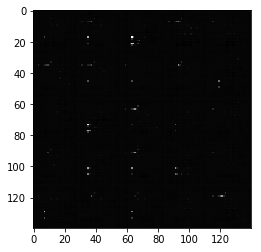

Epoch 2/10... Batch 610... Discriminator Loss: 0.0000... Generator Loss: 62.8778
Epoch 2/10... Batch 620... Discriminator Loss: 0.0000... Generator Loss: 56.7358
Epoch 2/10... Batch 630... Discriminator Loss: 0.0000... Generator Loss: 53.1198
Epoch 2/10... Batch 640... Discriminator Loss: 0.0000... Generator Loss: 45.4927
Epoch 2/10... Batch 650... Discriminator Loss: 1.4810... Generator Loss: 26.6310
Epoch 2/10... Batch 660... Discriminator Loss: 0.0000... Generator Loss: 476.3759
Epoch 2/10... Batch 670... Discriminator Loss: 0.0000... Generator Loss: 270.7665
Epoch 2/10... Batch 680... Discriminator Loss: 111.8121... Generator Loss: 229.7613
Epoch 2/10... Batch 690... Discriminator Loss: 0.0000... Generator Loss: 635.6934
Epoch 2/10... Batch 700... Discriminator Loss: 5.4987... Generator Loss: 394.1897


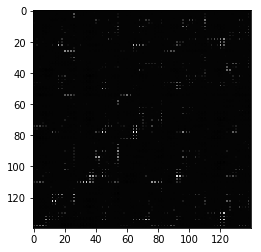

Epoch 2/10... Batch 710... Discriminator Loss: 0.5678... Generator Loss: 200.6955
Epoch 2/10... Batch 720... Discriminator Loss: 0.0000... Generator Loss: 225.0282
Epoch 2/10... Batch 730... Discriminator Loss: 0.0000... Generator Loss: 188.7724
Epoch 2/10... Batch 740... Discriminator Loss: 0.0000... Generator Loss: 265.0421
Epoch 2/10... Batch 750... Discriminator Loss: 0.0000... Generator Loss: 226.6781
Epoch 2/10... Batch 760... Discriminator Loss: 0.0000... Generator Loss: 218.6501
Epoch 2/10... Batch 770... Discriminator Loss: 0.0000... Generator Loss: 350.9922
Epoch 2/10... Batch 780... Discriminator Loss: 0.0000... Generator Loss: 302.9393
Epoch 2/10... Batch 790... Discriminator Loss: 0.0000... Generator Loss: 229.0055
Epoch 2/10... Batch 800... Discriminator Loss: 0.0000... Generator Loss: 228.0946


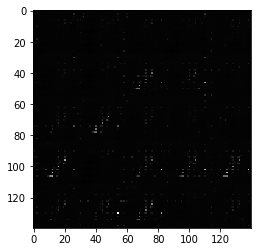

Epoch 2/10... Batch 810... Discriminator Loss: 0.0584... Generator Loss: 141.1596
Epoch 2/10... Batch 820... Discriminator Loss: 0.0000... Generator Loss: 851.8425
Epoch 2/10... Batch 830... Discriminator Loss: 0.7337... Generator Loss: 270.4273
Epoch 2/10... Batch 840... Discriminator Loss: 0.0000... Generator Loss: 342.6005
Epoch 2/10... Batch 850... Discriminator Loss: 0.3858... Generator Loss: 120.9428
Epoch 2/10... Batch 860... Discriminator Loss: 1.4204... Generator Loss: 478.0155
Epoch 2/10... Batch 870... Discriminator Loss: 0.1533... Generator Loss: 239.3524
Epoch 2/10... Batch 880... Discriminator Loss: 26.1340... Generator Loss: 5.3399
Epoch 2/10... Batch 890... Discriminator Loss: 0.5524... Generator Loss: 14.9844
Epoch 2/10... Batch 900... Discriminator Loss: 0.8210... Generator Loss: 21.3267


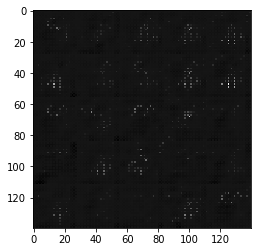

Epoch 2/10... Batch 910... Discriminator Loss: 0.0843... Generator Loss: 15.9238
Epoch 2/10... Batch 920... Discriminator Loss: 0.2031... Generator Loss: 22.7762
Epoch 2/10... Batch 930... Discriminator Loss: 0.7391... Generator Loss: 25.8840
Epoch 3/10... Batch 940... Discriminator Loss: 13.4594... Generator Loss: 2.2222
Epoch 3/10... Batch 950... Discriminator Loss: 0.9619... Generator Loss: 19.1697
Epoch 3/10... Batch 960... Discriminator Loss: 5.8593... Generator Loss: 6.4367
Epoch 3/10... Batch 970... Discriminator Loss: 0.0583... Generator Loss: 16.8869
Epoch 3/10... Batch 980... Discriminator Loss: 0.0927... Generator Loss: 18.9418
Epoch 3/10... Batch 990... Discriminator Loss: 0.2636... Generator Loss: 18.9176
Epoch 3/10... Batch 1000... Discriminator Loss: 0.2840... Generator Loss: 13.2446


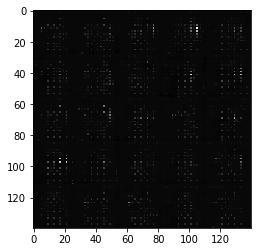

Epoch 3/10... Batch 1010... Discriminator Loss: 0.2803... Generator Loss: 18.9088
Epoch 3/10... Batch 1020... Discriminator Loss: 0.0739... Generator Loss: 15.5086
Epoch 3/10... Batch 1030... Discriminator Loss: 0.1170... Generator Loss: 17.3503
Epoch 3/10... Batch 1040... Discriminator Loss: 0.1553... Generator Loss: 13.1559
Epoch 3/10... Batch 1050... Discriminator Loss: 0.0448... Generator Loss: 16.8680
Epoch 3/10... Batch 1060... Discriminator Loss: 0.0045... Generator Loss: 15.3144
Epoch 3/10... Batch 1070... Discriminator Loss: 0.0262... Generator Loss: 13.5153
Epoch 3/10... Batch 1080... Discriminator Loss: 0.0887... Generator Loss: 13.3868
Epoch 3/10... Batch 1090... Discriminator Loss: 0.0090... Generator Loss: 13.7557
Epoch 3/10... Batch 1100... Discriminator Loss: 0.0236... Generator Loss: 13.9756


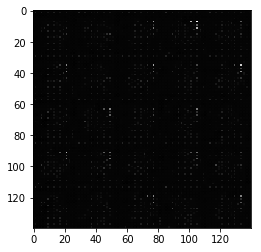

Epoch 3/10... Batch 1110... Discriminator Loss: 0.0601... Generator Loss: 16.6977
Epoch 3/10... Batch 1120... Discriminator Loss: 0.0255... Generator Loss: 17.1163
Epoch 3/10... Batch 1130... Discriminator Loss: 0.0948... Generator Loss: 13.9527
Epoch 3/10... Batch 1140... Discriminator Loss: 0.0674... Generator Loss: 13.0930
Epoch 3/10... Batch 1150... Discriminator Loss: 0.0974... Generator Loss: 10.4991
Epoch 3/10... Batch 1160... Discriminator Loss: 0.0129... Generator Loss: 16.5113
Epoch 3/10... Batch 1170... Discriminator Loss: 0.1275... Generator Loss: 9.8267
Epoch 3/10... Batch 1180... Discriminator Loss: 0.1165... Generator Loss: 16.7063
Epoch 3/10... Batch 1190... Discriminator Loss: 0.3601... Generator Loss: 8.8715
Epoch 3/10... Batch 1200... Discriminator Loss: 0.1341... Generator Loss: 7.9799


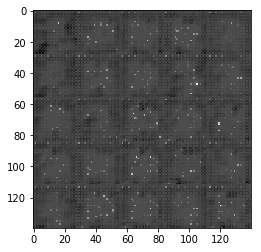

Epoch 3/10... Batch 1210... Discriminator Loss: 0.2054... Generator Loss: 6.6917
Epoch 3/10... Batch 1220... Discriminator Loss: 0.3911... Generator Loss: 6.0392
Epoch 3/10... Batch 1230... Discriminator Loss: 0.1027... Generator Loss: 8.3648
Epoch 3/10... Batch 1240... Discriminator Loss: 0.1007... Generator Loss: 7.4766
Epoch 3/10... Batch 1250... Discriminator Loss: 0.1787... Generator Loss: 10.4279
Epoch 3/10... Batch 1260... Discriminator Loss: 0.0959... Generator Loss: 7.4059
Epoch 3/10... Batch 1270... Discriminator Loss: 0.1926... Generator Loss: 8.0185
Epoch 3/10... Batch 1280... Discriminator Loss: 0.1618... Generator Loss: 7.1402
Epoch 3/10... Batch 1290... Discriminator Loss: 0.3876... Generator Loss: 4.1755
Epoch 3/10... Batch 1300... Discriminator Loss: 0.1106... Generator Loss: 6.4649


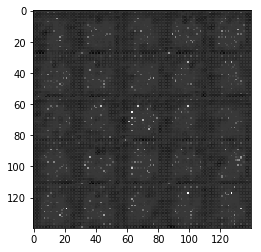

Epoch 3/10... Batch 1310... Discriminator Loss: 0.2380... Generator Loss: 5.8892
Epoch 3/10... Batch 1320... Discriminator Loss: 0.4818... Generator Loss: 8.7654
Epoch 3/10... Batch 1330... Discriminator Loss: 0.3980... Generator Loss: 10.1709
Epoch 3/10... Batch 1340... Discriminator Loss: 0.1729... Generator Loss: 5.6939
Epoch 3/10... Batch 1350... Discriminator Loss: 0.5421... Generator Loss: 3.1132
Epoch 3/10... Batch 1360... Discriminator Loss: 0.3112... Generator Loss: 7.8925
Epoch 3/10... Batch 1370... Discriminator Loss: 0.2075... Generator Loss: 4.6191
Epoch 3/10... Batch 1380... Discriminator Loss: 0.1283... Generator Loss: 5.9821
Epoch 3/10... Batch 1390... Discriminator Loss: 0.0652... Generator Loss: 6.1479
Epoch 3/10... Batch 1400... Discriminator Loss: 0.0724... Generator Loss: 5.9823


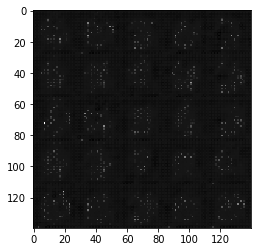

Epoch 4/10... Batch 1410... Discriminator Loss: 0.1134... Generator Loss: 4.8691
Epoch 4/10... Batch 1420... Discriminator Loss: 0.4392... Generator Loss: 8.9393
Epoch 4/10... Batch 1430... Discriminator Loss: 0.0921... Generator Loss: 4.8153
Epoch 4/10... Batch 1440... Discriminator Loss: 0.0655... Generator Loss: 5.7070
Epoch 4/10... Batch 1450... Discriminator Loss: 0.0630... Generator Loss: 5.5598
Epoch 4/10... Batch 1460... Discriminator Loss: 0.0600... Generator Loss: 4.9479
Epoch 4/10... Batch 1470... Discriminator Loss: 0.0634... Generator Loss: 5.9606
Epoch 4/10... Batch 1480... Discriminator Loss: 0.0439... Generator Loss: 5.5795
Epoch 4/10... Batch 1490... Discriminator Loss: 0.0423... Generator Loss: 5.2686
Epoch 4/10... Batch 1500... Discriminator Loss: 0.1753... Generator Loss: 3.4441


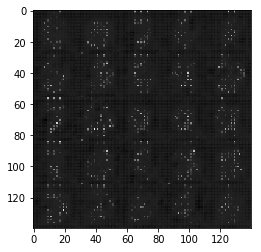

Epoch 4/10... Batch 1510... Discriminator Loss: 0.0558... Generator Loss: 6.1273
Epoch 4/10... Batch 1520... Discriminator Loss: 0.0269... Generator Loss: 6.0215
Epoch 4/10... Batch 1530... Discriminator Loss: 0.0253... Generator Loss: 5.9026
Epoch 4/10... Batch 1540... Discriminator Loss: 0.0358... Generator Loss: 5.4887
Epoch 4/10... Batch 1550... Discriminator Loss: 0.0605... Generator Loss: 4.9554
Epoch 4/10... Batch 1560... Discriminator Loss: 0.0911... Generator Loss: 4.2276
Epoch 4/10... Batch 1570... Discriminator Loss: 0.0421... Generator Loss: 5.8401
Epoch 4/10... Batch 1580... Discriminator Loss: 0.4908... Generator Loss: 12.4102
Epoch 4/10... Batch 1590... Discriminator Loss: 0.0618... Generator Loss: 5.4439
Epoch 4/10... Batch 1600... Discriminator Loss: 0.0573... Generator Loss: 5.3164


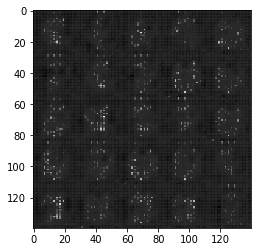

Epoch 4/10... Batch 1610... Discriminator Loss: 0.0322... Generator Loss: 5.7809
Epoch 4/10... Batch 1620... Discriminator Loss: 0.0436... Generator Loss: 5.3635
Epoch 4/10... Batch 1630... Discriminator Loss: 0.0485... Generator Loss: 5.0984
Epoch 4/10... Batch 1640... Discriminator Loss: 0.0652... Generator Loss: 5.3811
Epoch 4/10... Batch 1650... Discriminator Loss: 0.0523... Generator Loss: 5.4337
Epoch 4/10... Batch 1660... Discriminator Loss: 0.0681... Generator Loss: 5.5437
Epoch 4/10... Batch 1670... Discriminator Loss: 0.1023... Generator Loss: 5.2931
Epoch 4/10... Batch 1680... Discriminator Loss: 0.1403... Generator Loss: 6.1746
Epoch 4/10... Batch 1690... Discriminator Loss: 0.0395... Generator Loss: 5.9557
Epoch 4/10... Batch 1700... Discriminator Loss: 0.0537... Generator Loss: 5.8076


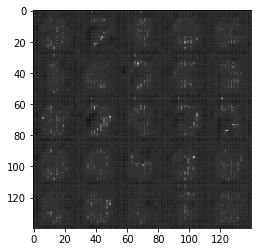

Epoch 4/10... Batch 1710... Discriminator Loss: 0.0510... Generator Loss: 5.5615
Epoch 4/10... Batch 1720... Discriminator Loss: 0.0463... Generator Loss: 5.0457
Epoch 4/10... Batch 1730... Discriminator Loss: 0.0553... Generator Loss: 5.6051
Epoch 4/10... Batch 1740... Discriminator Loss: 0.0260... Generator Loss: 5.9262
Epoch 4/10... Batch 1750... Discriminator Loss: 0.0505... Generator Loss: 5.1103
Epoch 4/10... Batch 1760... Discriminator Loss: 0.0801... Generator Loss: 4.3031
Epoch 4/10... Batch 1770... Discriminator Loss: 0.0439... Generator Loss: 4.8749
Epoch 4/10... Batch 1780... Discriminator Loss: 0.1138... Generator Loss: 3.6230
Epoch 4/10... Batch 1790... Discriminator Loss: 0.0786... Generator Loss: 5.1565
Epoch 4/10... Batch 1800... Discriminator Loss: 0.0670... Generator Loss: 4.4539


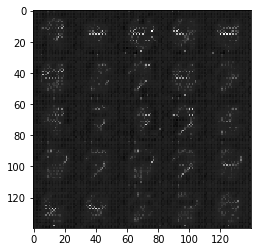

Epoch 4/10... Batch 1810... Discriminator Loss: 0.0290... Generator Loss: 5.1526
Epoch 4/10... Batch 1820... Discriminator Loss: 0.0247... Generator Loss: 5.2633
Epoch 4/10... Batch 1830... Discriminator Loss: 0.0251... Generator Loss: 5.1605
Epoch 4/10... Batch 1840... Discriminator Loss: 0.0298... Generator Loss: 5.5665
Epoch 4/10... Batch 1850... Discriminator Loss: 0.0468... Generator Loss: 5.2595
Epoch 4/10... Batch 1860... Discriminator Loss: 0.0220... Generator Loss: 5.1898
Epoch 4/10... Batch 1870... Discriminator Loss: 0.0528... Generator Loss: 5.1477
Epoch 5/10... Batch 1880... Discriminator Loss: 0.0396... Generator Loss: 5.1201
Epoch 5/10... Batch 1890... Discriminator Loss: 0.0429... Generator Loss: 5.5875
Epoch 5/10... Batch 1900... Discriminator Loss: 0.0522... Generator Loss: 4.1189


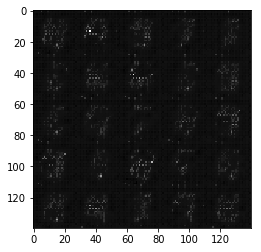

Epoch 5/10... Batch 1910... Discriminator Loss: 0.0445... Generator Loss: 4.8541
Epoch 5/10... Batch 1920... Discriminator Loss: 0.0375... Generator Loss: 4.4849
Epoch 5/10... Batch 1930... Discriminator Loss: 0.0218... Generator Loss: 4.9355
Epoch 5/10... Batch 1940... Discriminator Loss: 0.0343... Generator Loss: 4.9789
Epoch 5/10... Batch 1950... Discriminator Loss: 0.0272... Generator Loss: 5.2483
Epoch 5/10... Batch 1960... Discriminator Loss: 0.0484... Generator Loss: 4.5283
Epoch 5/10... Batch 1970... Discriminator Loss: 0.0219... Generator Loss: 5.7754
Epoch 5/10... Batch 1980... Discriminator Loss: 0.0231... Generator Loss: 5.2682
Epoch 5/10... Batch 1990... Discriminator Loss: 0.0851... Generator Loss: 4.0208
Epoch 5/10... Batch 2000... Discriminator Loss: 0.0387... Generator Loss: 5.8261


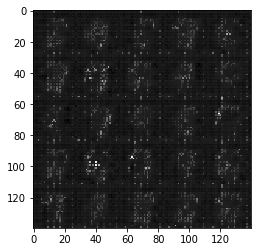

Epoch 5/10... Batch 2010... Discriminator Loss: 0.0378... Generator Loss: 6.4883
Epoch 5/10... Batch 2020... Discriminator Loss: 0.0260... Generator Loss: 6.3434
Epoch 5/10... Batch 2030... Discriminator Loss: 0.0557... Generator Loss: 4.8938
Epoch 5/10... Batch 2040... Discriminator Loss: 0.0346... Generator Loss: 6.4613
Epoch 5/10... Batch 2050... Discriminator Loss: 0.0152... Generator Loss: 7.0098
Epoch 5/10... Batch 2060... Discriminator Loss: 0.0252... Generator Loss: 5.4137
Epoch 5/10... Batch 2070... Discriminator Loss: 0.0215... Generator Loss: 5.6655
Epoch 5/10... Batch 2080... Discriminator Loss: 0.0206... Generator Loss: 6.0138
Epoch 5/10... Batch 2090... Discriminator Loss: 0.0197... Generator Loss: 5.8396
Epoch 5/10... Batch 2100... Discriminator Loss: 0.0139... Generator Loss: 6.3239


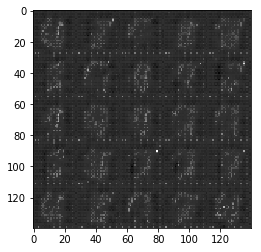

Epoch 5/10... Batch 2110... Discriminator Loss: 0.0211... Generator Loss: 5.8182
Epoch 5/10... Batch 2120... Discriminator Loss: 0.0140... Generator Loss: 6.2401
Epoch 5/10... Batch 2130... Discriminator Loss: 0.0340... Generator Loss: 6.0312
Epoch 5/10... Batch 2140... Discriminator Loss: 0.0242... Generator Loss: 5.1945
Epoch 5/10... Batch 2150... Discriminator Loss: 0.0314... Generator Loss: 5.3238
Epoch 5/10... Batch 2160... Discriminator Loss: 0.3692... Generator Loss: 3.2489
Epoch 5/10... Batch 2170... Discriminator Loss: 0.1135... Generator Loss: 3.8072
Epoch 5/10... Batch 2180... Discriminator Loss: 0.0959... Generator Loss: 4.1942
Epoch 5/10... Batch 2190... Discriminator Loss: 0.1000... Generator Loss: 4.7735
Epoch 5/10... Batch 2200... Discriminator Loss: 0.0966... Generator Loss: 4.6302


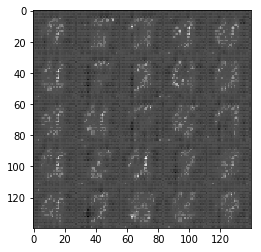

Epoch 5/10... Batch 2210... Discriminator Loss: 3.4556... Generator Loss: 14.9070
Epoch 5/10... Batch 2220... Discriminator Loss: 0.0391... Generator Loss: 5.6891
Epoch 5/10... Batch 2230... Discriminator Loss: 0.0339... Generator Loss: 5.6535
Epoch 5/10... Batch 2240... Discriminator Loss: 0.0427... Generator Loss: 5.5506
Epoch 5/10... Batch 2250... Discriminator Loss: 0.0554... Generator Loss: 5.7425
Epoch 5/10... Batch 2260... Discriminator Loss: 0.0341... Generator Loss: 5.8499
Epoch 5/10... Batch 2270... Discriminator Loss: 0.0502... Generator Loss: 5.1281
Epoch 5/10... Batch 2280... Discriminator Loss: 0.0853... Generator Loss: 5.2450
Epoch 5/10... Batch 2290... Discriminator Loss: 0.0804... Generator Loss: 5.3181
Epoch 5/10... Batch 2300... Discriminator Loss: 0.0420... Generator Loss: 6.8863


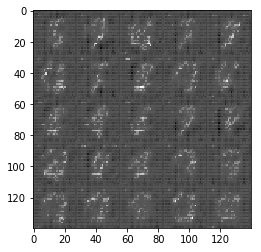

Epoch 5/10... Batch 2310... Discriminator Loss: 0.1334... Generator Loss: 7.4859
Epoch 5/10... Batch 2320... Discriminator Loss: 1.2516... Generator Loss: 1.4665
Epoch 5/10... Batch 2330... Discriminator Loss: 0.1853... Generator Loss: 3.2499
Epoch 5/10... Batch 2340... Discriminator Loss: 0.0830... Generator Loss: 3.9382
Epoch 6/10... Batch 2350... Discriminator Loss: 0.0687... Generator Loss: 4.5826
Epoch 6/10... Batch 2360... Discriminator Loss: 0.0844... Generator Loss: 4.1934
Epoch 6/10... Batch 2370... Discriminator Loss: 0.0572... Generator Loss: 5.2381
Epoch 6/10... Batch 2380... Discriminator Loss: 0.0724... Generator Loss: 4.2402
Epoch 6/10... Batch 2390... Discriminator Loss: 0.0859... Generator Loss: 4.5409
Epoch 6/10... Batch 2400... Discriminator Loss: 0.1222... Generator Loss: 3.6056


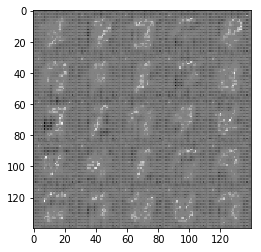

Epoch 6/10... Batch 2410... Discriminator Loss: 0.0562... Generator Loss: 4.9483
Epoch 6/10... Batch 2420... Discriminator Loss: 0.0525... Generator Loss: 5.2197
Epoch 6/10... Batch 2430... Discriminator Loss: 0.0304... Generator Loss: 5.5910
Epoch 6/10... Batch 2440... Discriminator Loss: 0.0447... Generator Loss: 5.6895
Epoch 6/10... Batch 2450... Discriminator Loss: 0.0438... Generator Loss: 5.9470
Epoch 6/10... Batch 2460... Discriminator Loss: 0.0341... Generator Loss: 6.0381
Epoch 6/10... Batch 2470... Discriminator Loss: 0.0360... Generator Loss: 5.8732
Epoch 6/10... Batch 2480... Discriminator Loss: 0.0411... Generator Loss: 5.8668
Epoch 6/10... Batch 2490... Discriminator Loss: 0.0563... Generator Loss: 5.6217
Epoch 6/10... Batch 2500... Discriminator Loss: 0.0476... Generator Loss: 6.3332


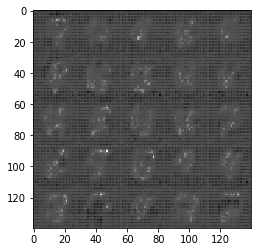

Epoch 6/10... Batch 2510... Discriminator Loss: 6.3784... Generator Loss: 9.6842
Epoch 6/10... Batch 2520... Discriminator Loss: 0.0772... Generator Loss: 5.2755
Epoch 6/10... Batch 2530... Discriminator Loss: 0.0691... Generator Loss: 4.7669
Epoch 6/10... Batch 2540... Discriminator Loss: 0.0718... Generator Loss: 5.1924
Epoch 6/10... Batch 2550... Discriminator Loss: 0.0422... Generator Loss: 5.6731
Epoch 6/10... Batch 2560... Discriminator Loss: 0.0365... Generator Loss: 6.3209
Epoch 6/10... Batch 2570... Discriminator Loss: 0.0357... Generator Loss: 6.5379
Epoch 6/10... Batch 2580... Discriminator Loss: 0.0515... Generator Loss: 6.5993
Epoch 6/10... Batch 2590... Discriminator Loss: 0.0425... Generator Loss: 6.7889
Epoch 6/10... Batch 2600... Discriminator Loss: 0.0490... Generator Loss: 7.0832


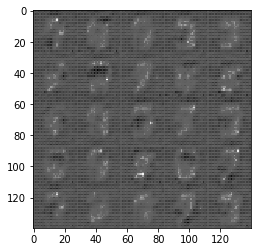

Epoch 6/10... Batch 2610... Discriminator Loss: 0.0308... Generator Loss: 7.3247
Epoch 6/10... Batch 2620... Discriminator Loss: 0.0204... Generator Loss: 7.8897
Epoch 6/10... Batch 2630... Discriminator Loss: 0.0240... Generator Loss: 7.3645
Epoch 6/10... Batch 2640... Discriminator Loss: 0.0177... Generator Loss: 7.8088
Epoch 6/10... Batch 2650... Discriminator Loss: 0.0175... Generator Loss: 7.2512
Epoch 6/10... Batch 2660... Discriminator Loss: 0.0640... Generator Loss: 5.9736
Epoch 6/10... Batch 2670... Discriminator Loss: 1.1949... Generator Loss: 0.8089
Epoch 6/10... Batch 2680... Discriminator Loss: 0.3547... Generator Loss: 2.5803
Epoch 6/10... Batch 2690... Discriminator Loss: 0.1308... Generator Loss: 3.6074
Epoch 6/10... Batch 2700... Discriminator Loss: 0.1205... Generator Loss: 4.3366


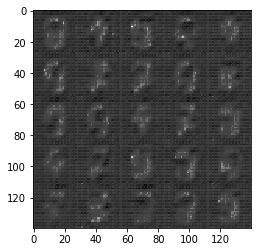

Epoch 6/10... Batch 2710... Discriminator Loss: 0.1409... Generator Loss: 6.2279
Epoch 6/10... Batch 2720... Discriminator Loss: 0.1813... Generator Loss: 3.1000
Epoch 6/10... Batch 2730... Discriminator Loss: 0.0697... Generator Loss: 4.0715
Epoch 6/10... Batch 2740... Discriminator Loss: 0.0605... Generator Loss: 3.9705
Epoch 6/10... Batch 2750... Discriminator Loss: 0.0584... Generator Loss: 4.4020
Epoch 6/10... Batch 2760... Discriminator Loss: 0.0509... Generator Loss: 4.7240
Epoch 6/10... Batch 2770... Discriminator Loss: 0.0591... Generator Loss: 4.5539
Epoch 6/10... Batch 2780... Discriminator Loss: 0.0486... Generator Loss: 5.4557
Epoch 6/10... Batch 2790... Discriminator Loss: 0.0487... Generator Loss: 4.7797
Epoch 6/10... Batch 2800... Discriminator Loss: 0.0362... Generator Loss: 5.0018


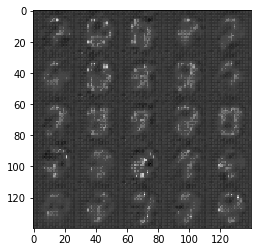

Epoch 7/10... Batch 2810... Discriminator Loss: 0.0264... Generator Loss: 6.0056
Epoch 7/10... Batch 2820... Discriminator Loss: 0.0396... Generator Loss: 5.4952
Epoch 7/10... Batch 2830... Discriminator Loss: 4.3510... Generator Loss: 0.1659
Epoch 7/10... Batch 2840... Discriminator Loss: 9.1312... Generator Loss: 12.0172
Epoch 7/10... Batch 2850... Discriminator Loss: 0.2090... Generator Loss: 3.4503
Epoch 7/10... Batch 2860... Discriminator Loss: 0.3742... Generator Loss: 1.7513
Epoch 7/10... Batch 2870... Discriminator Loss: 0.0895... Generator Loss: 3.5076
Epoch 7/10... Batch 2880... Discriminator Loss: 0.0726... Generator Loss: 4.0744
Epoch 7/10... Batch 2890... Discriminator Loss: 0.0612... Generator Loss: 4.7186
Epoch 7/10... Batch 2900... Discriminator Loss: 0.4036... Generator Loss: 3.0687


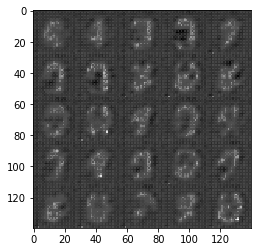

Epoch 7/10... Batch 2910... Discriminator Loss: 0.0681... Generator Loss: 4.0201
Epoch 7/10... Batch 2920... Discriminator Loss: 0.0637... Generator Loss: 4.1237
Epoch 7/10... Batch 2930... Discriminator Loss: 1.0843... Generator Loss: 0.7489
Epoch 7/10... Batch 2940... Discriminator Loss: 0.0776... Generator Loss: 3.8258
Epoch 7/10... Batch 2950... Discriminator Loss: 0.1230... Generator Loss: 3.5225
Epoch 7/10... Batch 2960... Discriminator Loss: 0.0584... Generator Loss: 4.3978
Epoch 7/10... Batch 2970... Discriminator Loss: 0.0849... Generator Loss: 4.1908
Epoch 7/10... Batch 2980... Discriminator Loss: 0.0623... Generator Loss: 4.7262
Epoch 7/10... Batch 2990... Discriminator Loss: 0.4249... Generator Loss: 1.5856
Epoch 7/10... Batch 3000... Discriminator Loss: 0.1042... Generator Loss: 3.6809


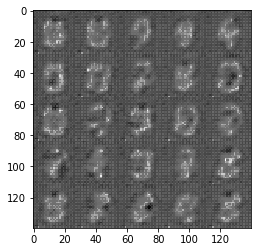

Epoch 7/10... Batch 3010... Discriminator Loss: 0.1015... Generator Loss: 3.7384
Epoch 7/10... Batch 3020... Discriminator Loss: 0.0572... Generator Loss: 5.6304
Epoch 7/10... Batch 3030... Discriminator Loss: 0.0475... Generator Loss: 5.0144
Epoch 7/10... Batch 3040... Discriminator Loss: 0.1595... Generator Loss: 6.2458
Epoch 7/10... Batch 3050... Discriminator Loss: 0.2059... Generator Loss: 3.2480
Epoch 7/10... Batch 3060... Discriminator Loss: 0.2221... Generator Loss: 5.0120
Epoch 7/10... Batch 3070... Discriminator Loss: 0.1258... Generator Loss: 3.6446
Epoch 7/10... Batch 3080... Discriminator Loss: 0.1102... Generator Loss: 3.6025
Epoch 7/10... Batch 3090... Discriminator Loss: 0.0456... Generator Loss: 4.9579
Epoch 7/10... Batch 3100... Discriminator Loss: 0.1965... Generator Loss: 3.1244


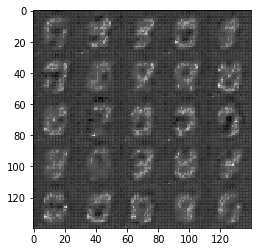

Epoch 7/10... Batch 3110... Discriminator Loss: 0.0343... Generator Loss: 5.2030
Epoch 7/10... Batch 3120... Discriminator Loss: 0.0555... Generator Loss: 4.8395
Epoch 7/10... Batch 3130... Discriminator Loss: 0.0435... Generator Loss: 5.0033
Epoch 7/10... Batch 3140... Discriminator Loss: 0.0472... Generator Loss: 4.7596
Epoch 7/10... Batch 3150... Discriminator Loss: 0.0155... Generator Loss: 6.3380
Epoch 7/10... Batch 3160... Discriminator Loss: 5.0209... Generator Loss: 0.1756
Epoch 7/10... Batch 3170... Discriminator Loss: 0.4200... Generator Loss: 2.4747
Epoch 7/10... Batch 3180... Discriminator Loss: 0.1943... Generator Loss: 3.3914
Epoch 7/10... Batch 3190... Discriminator Loss: 0.2666... Generator Loss: 6.0011
Epoch 7/10... Batch 3200... Discriminator Loss: 0.1055... Generator Loss: 3.5659


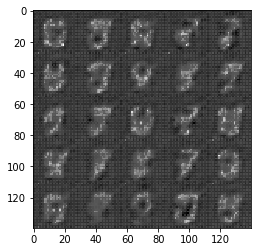

Epoch 7/10... Batch 3210... Discriminator Loss: 0.1465... Generator Loss: 3.5188
Epoch 7/10... Batch 3220... Discriminator Loss: 0.1871... Generator Loss: 3.5906
Epoch 7/10... Batch 3230... Discriminator Loss: 0.1026... Generator Loss: 3.9224
Epoch 7/10... Batch 3240... Discriminator Loss: 0.0464... Generator Loss: 5.4907
Epoch 7/10... Batch 3250... Discriminator Loss: 0.0338... Generator Loss: 5.3361
Epoch 7/10... Batch 3260... Discriminator Loss: 0.0585... Generator Loss: 4.7146
Epoch 7/10... Batch 3270... Discriminator Loss: 0.0469... Generator Loss: 5.6526
Epoch 8/10... Batch 3280... Discriminator Loss: 0.0259... Generator Loss: 6.4729
Epoch 8/10... Batch 3290... Discriminator Loss: 0.0266... Generator Loss: 6.4700
Epoch 8/10... Batch 3300... Discriminator Loss: 0.0228... Generator Loss: 6.7070


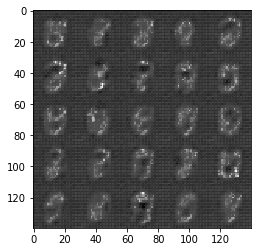

Epoch 8/10... Batch 3310... Discriminator Loss: 0.0265... Generator Loss: 5.6363
Epoch 8/10... Batch 3320... Discriminator Loss: 0.0585... Generator Loss: 4.2280
Epoch 8/10... Batch 3330... Discriminator Loss: 0.0138... Generator Loss: 6.4707
Epoch 8/10... Batch 3340... Discriminator Loss: 0.0323... Generator Loss: 5.5623
Epoch 8/10... Batch 3350... Discriminator Loss: 0.0084... Generator Loss: 6.8091
Epoch 8/10... Batch 3360... Discriminator Loss: 0.0475... Generator Loss: 5.7855
Epoch 8/10... Batch 3370... Discriminator Loss: 2.9820... Generator Loss: 0.5726
Epoch 8/10... Batch 3380... Discriminator Loss: 0.2243... Generator Loss: 2.8705
Epoch 8/10... Batch 3390... Discriminator Loss: 0.2533... Generator Loss: 2.3222
Epoch 8/10... Batch 3400... Discriminator Loss: 0.1582... Generator Loss: 3.5430


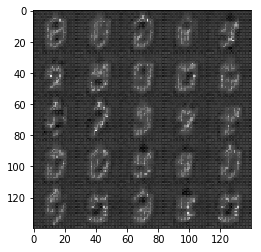

Epoch 8/10... Batch 3410... Discriminator Loss: 0.1991... Generator Loss: 2.8570
Epoch 8/10... Batch 3420... Discriminator Loss: 0.1214... Generator Loss: 3.2857
Epoch 8/10... Batch 3430... Discriminator Loss: 0.1760... Generator Loss: 2.7789
Epoch 8/10... Batch 3440... Discriminator Loss: 0.1009... Generator Loss: 4.2281
Epoch 8/10... Batch 3450... Discriminator Loss: 0.2772... Generator Loss: 2.8653
Epoch 8/10... Batch 3460... Discriminator Loss: 0.2282... Generator Loss: 3.1274
Epoch 8/10... Batch 3470... Discriminator Loss: 1.2142... Generator Loss: 0.7725
Epoch 8/10... Batch 3480... Discriminator Loss: 0.1967... Generator Loss: 2.8346
Epoch 8/10... Batch 3490... Discriminator Loss: 0.1189... Generator Loss: 4.0354
Epoch 8/10... Batch 3500... Discriminator Loss: 2.9765... Generator Loss: 12.7040


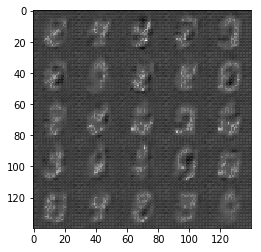

Epoch 8/10... Batch 3510... Discriminator Loss: 0.1481... Generator Loss: 2.9177
Epoch 8/10... Batch 3520... Discriminator Loss: 0.2633... Generator Loss: 2.3097
Epoch 8/10... Batch 3530... Discriminator Loss: 0.1194... Generator Loss: 3.5043
Epoch 8/10... Batch 3540... Discriminator Loss: 0.1457... Generator Loss: 2.9830
Epoch 8/10... Batch 3550... Discriminator Loss: 0.5331... Generator Loss: 1.6592
Epoch 8/10... Batch 3560... Discriminator Loss: 0.0518... Generator Loss: 4.4456
Epoch 8/10... Batch 3570... Discriminator Loss: 0.0470... Generator Loss: 4.5194
Epoch 8/10... Batch 3580... Discriminator Loss: 0.1193... Generator Loss: 6.0664
Epoch 8/10... Batch 3590... Discriminator Loss: 0.2546... Generator Loss: 2.6012
Epoch 8/10... Batch 3600... Discriminator Loss: 0.1955... Generator Loss: 2.8047


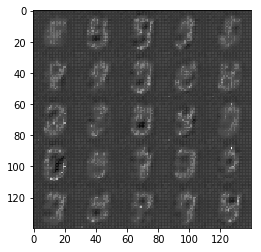

Epoch 8/10... Batch 3610... Discriminator Loss: 0.1850... Generator Loss: 4.7547
Epoch 8/10... Batch 3620... Discriminator Loss: 0.1945... Generator Loss: 2.7653
Epoch 8/10... Batch 3630... Discriminator Loss: 0.1367... Generator Loss: 3.1957
Epoch 8/10... Batch 3640... Discriminator Loss: 0.0444... Generator Loss: 4.5275
Epoch 8/10... Batch 3650... Discriminator Loss: 0.0547... Generator Loss: 4.3905
Epoch 8/10... Batch 3660... Discriminator Loss: 0.1374... Generator Loss: 3.3306
Epoch 8/10... Batch 3670... Discriminator Loss: 0.1858... Generator Loss: 2.8288
Epoch 8/10... Batch 3680... Discriminator Loss: 0.2961... Generator Loss: 2.2601
Epoch 8/10... Batch 3690... Discriminator Loss: 0.1375... Generator Loss: 3.3930
Epoch 8/10... Batch 3700... Discriminator Loss: 0.1254... Generator Loss: 3.1919


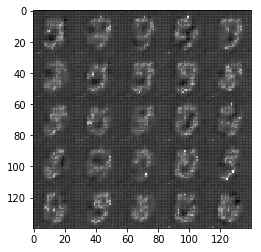

Epoch 8/10... Batch 3710... Discriminator Loss: 0.0488... Generator Loss: 5.5143
Epoch 8/10... Batch 3720... Discriminator Loss: 0.1433... Generator Loss: 7.4332
Epoch 8/10... Batch 3730... Discriminator Loss: 0.0406... Generator Loss: 5.6409
Epoch 8/10... Batch 3740... Discriminator Loss: 1.0951... Generator Loss: 5.6404
Epoch 9/10... Batch 3750... Discriminator Loss: 1.1085... Generator Loss: 9.2480
Epoch 9/10... Batch 3760... Discriminator Loss: 0.1421... Generator Loss: 3.3981
Epoch 9/10... Batch 3770... Discriminator Loss: 0.1870... Generator Loss: 3.9926
Epoch 9/10... Batch 3780... Discriminator Loss: 0.0949... Generator Loss: 4.9179
Epoch 9/10... Batch 3790... Discriminator Loss: 0.1895... Generator Loss: 3.0843
Epoch 9/10... Batch 3800... Discriminator Loss: 0.1274... Generator Loss: 3.8769


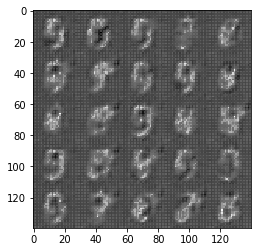

Epoch 9/10... Batch 3810... Discriminator Loss: 0.0856... Generator Loss: 4.2553
Epoch 9/10... Batch 3820... Discriminator Loss: 0.0876... Generator Loss: 4.1275
Epoch 9/10... Batch 3830... Discriminator Loss: 0.0725... Generator Loss: 4.6945
Epoch 9/10... Batch 3840... Discriminator Loss: 0.0447... Generator Loss: 5.2293
Epoch 9/10... Batch 3850... Discriminator Loss: 0.0327... Generator Loss: 5.9956
Epoch 9/10... Batch 3860... Discriminator Loss: 0.1280... Generator Loss: 7.5612
Epoch 9/10... Batch 3870... Discriminator Loss: 0.2639... Generator Loss: 4.5622
Epoch 9/10... Batch 3880... Discriminator Loss: 0.2771... Generator Loss: 5.3175
Epoch 9/10... Batch 3890... Discriminator Loss: 0.1445... Generator Loss: 4.0277
Epoch 9/10... Batch 3900... Discriminator Loss: 0.2004... Generator Loss: 3.2206


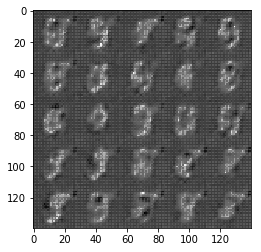

Epoch 9/10... Batch 3910... Discriminator Loss: 0.1548... Generator Loss: 4.8460
Epoch 9/10... Batch 3920... Discriminator Loss: 0.3189... Generator Loss: 6.1253
Epoch 9/10... Batch 3930... Discriminator Loss: 0.1335... Generator Loss: 7.0784
Epoch 9/10... Batch 3940... Discriminator Loss: 0.0397... Generator Loss: 6.2419
Epoch 9/10... Batch 3950... Discriminator Loss: 0.0430... Generator Loss: 6.1260
Epoch 9/10... Batch 3960... Discriminator Loss: 7.9027... Generator Loss: 19.0228
Epoch 9/10... Batch 3970... Discriminator Loss: 0.1772... Generator Loss: 4.8795
Epoch 9/10... Batch 3980... Discriminator Loss: 0.1013... Generator Loss: 3.5621
Epoch 9/10... Batch 3990... Discriminator Loss: 0.0389... Generator Loss: 5.2142
Epoch 9/10... Batch 4000... Discriminator Loss: 0.2563... Generator Loss: 2.6034


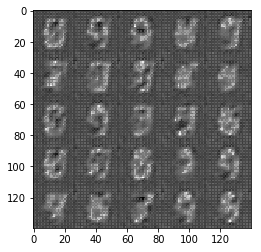

Epoch 9/10... Batch 4010... Discriminator Loss: 0.0765... Generator Loss: 3.7745
Epoch 9/10... Batch 4020... Discriminator Loss: 0.0792... Generator Loss: 3.9318
Epoch 9/10... Batch 4030... Discriminator Loss: 0.0530... Generator Loss: 4.7479
Epoch 9/10... Batch 4040... Discriminator Loss: 0.0430... Generator Loss: 5.0665
Epoch 9/10... Batch 4050... Discriminator Loss: 0.0316... Generator Loss: 5.4985
Epoch 9/10... Batch 4060... Discriminator Loss: 0.0433... Generator Loss: 5.0819
Epoch 9/10... Batch 4070... Discriminator Loss: 0.0512... Generator Loss: 5.2816
Epoch 9/10... Batch 4080... Discriminator Loss: 0.0194... Generator Loss: 6.3857
Epoch 9/10... Batch 4090... Discriminator Loss: 0.0190... Generator Loss: 6.8001
Epoch 9/10... Batch 4100... Discriminator Loss: 0.0136... Generator Loss: 6.7959


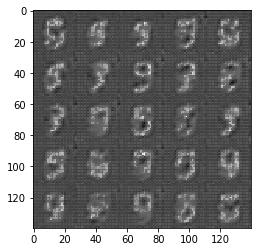

Epoch 9/10... Batch 4110... Discriminator Loss: 0.0237... Generator Loss: 8.0275
Epoch 9/10... Batch 4120... Discriminator Loss: 0.0411... Generator Loss: 5.6310
Epoch 9/10... Batch 4130... Discriminator Loss: 0.0041... Generator Loss: 9.2838
Epoch 9/10... Batch 4140... Discriminator Loss: 0.0274... Generator Loss: 5.8777
Epoch 9/10... Batch 4150... Discriminator Loss: 0.0713... Generator Loss: 4.8812
Epoch 9/10... Batch 4160... Discriminator Loss: 5.8391... Generator Loss: 0.1344
Epoch 9/10... Batch 4170... Discriminator Loss: 0.1793... Generator Loss: 6.2267
Epoch 9/10... Batch 4180... Discriminator Loss: 0.1151... Generator Loss: 5.2533
Epoch 9/10... Batch 4190... Discriminator Loss: 0.0405... Generator Loss: 6.1693
Epoch 9/10... Batch 4200... Discriminator Loss: 0.3372... Generator Loss: 2.1979


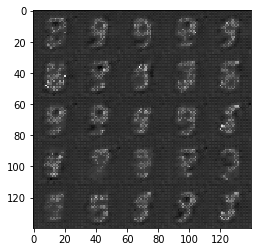

Epoch 9/10... Batch 4210... Discriminator Loss: 0.0822... Generator Loss: 3.4691
Epoch 10/10... Batch 4220... Discriminator Loss: 0.1077... Generator Loss: 3.4754
Epoch 10/10... Batch 4230... Discriminator Loss: 0.2547... Generator Loss: 2.4951
Epoch 10/10... Batch 4240... Discriminator Loss: 0.1957... Generator Loss: 2.5025
Epoch 10/10... Batch 4250... Discriminator Loss: 0.5843... Generator Loss: 1.4837
Epoch 10/10... Batch 4260... Discriminator Loss: 0.2601... Generator Loss: 2.8131
Epoch 10/10... Batch 4270... Discriminator Loss: 0.2600... Generator Loss: 2.3414
Epoch 10/10... Batch 4280... Discriminator Loss: 0.1883... Generator Loss: 3.1109
Epoch 10/10... Batch 4290... Discriminator Loss: 0.1155... Generator Loss: 3.6582
Epoch 10/10... Batch 4300... Discriminator Loss: 0.1071... Generator Loss: 5.0563


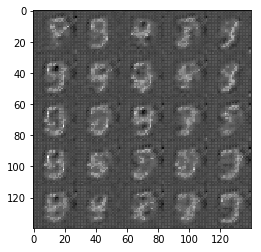

Epoch 10/10... Batch 4310... Discriminator Loss: 11.4718... Generator Loss: 15.5173
Epoch 10/10... Batch 4320... Discriminator Loss: 0.2508... Generator Loss: 2.8531
Epoch 10/10... Batch 4330... Discriminator Loss: 0.2895... Generator Loss: 2.6964
Epoch 10/10... Batch 4340... Discriminator Loss: 0.3905... Generator Loss: 4.2343
Epoch 10/10... Batch 4350... Discriminator Loss: 0.3369... Generator Loss: 2.5572
Epoch 10/10... Batch 4360... Discriminator Loss: 0.2929... Generator Loss: 3.2524
Epoch 10/10... Batch 4370... Discriminator Loss: 0.1688... Generator Loss: 3.0928
Epoch 10/10... Batch 4380... Discriminator Loss: 0.0660... Generator Loss: 4.8478
Epoch 10/10... Batch 4390... Discriminator Loss: 0.1225... Generator Loss: 4.4555
Epoch 10/10... Batch 4400... Discriminator Loss: 0.2976... Generator Loss: 6.0291


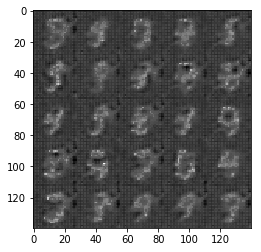

Epoch 10/10... Batch 4410... Discriminator Loss: 0.7519... Generator Loss: 1.3970
Epoch 10/10... Batch 4420... Discriminator Loss: 0.0491... Generator Loss: 5.0094
Epoch 10/10... Batch 4430... Discriminator Loss: 0.0870... Generator Loss: 4.3781
Epoch 10/10... Batch 4440... Discriminator Loss: 0.6573... Generator Loss: 9.2507
Epoch 10/10... Batch 4450... Discriminator Loss: 0.1089... Generator Loss: 4.0731
Epoch 10/10... Batch 4460... Discriminator Loss: 0.1036... Generator Loss: 4.0554
Epoch 10/10... Batch 4470... Discriminator Loss: 0.0939... Generator Loss: 4.9234
Epoch 10/10... Batch 4480... Discriminator Loss: 0.0580... Generator Loss: 6.2648
Epoch 10/10... Batch 4490... Discriminator Loss: 0.0453... Generator Loss: 5.8406
Epoch 10/10... Batch 4500... Discriminator Loss: 0.0394... Generator Loss: 6.9395


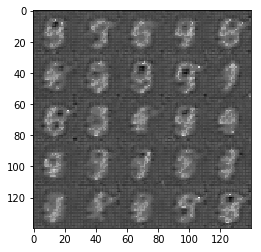

Epoch 10/10... Batch 4510... Discriminator Loss: 0.0582... Generator Loss: 6.5656
Epoch 10/10... Batch 4520... Discriminator Loss: 0.0504... Generator Loss: 5.6439
Epoch 10/10... Batch 4530... Discriminator Loss: 0.0206... Generator Loss: 5.9737
Epoch 10/10... Batch 4540... Discriminator Loss: 0.0208... Generator Loss: 6.4014
Epoch 10/10... Batch 4550... Discriminator Loss: 0.0365... Generator Loss: 6.4287
Epoch 10/10... Batch 4560... Discriminator Loss: 0.0439... Generator Loss: 5.6129
Epoch 10/10... Batch 4570... Discriminator Loss: 0.1530... Generator Loss: 10.2792
Epoch 10/10... Batch 4580... Discriminator Loss: 0.1871... Generator Loss: 3.4643
Epoch 10/10... Batch 4590... Discriminator Loss: 0.2622... Generator Loss: 7.7350
Epoch 10/10... Batch 4600... Discriminator Loss: 0.1134... Generator Loss: 3.9526


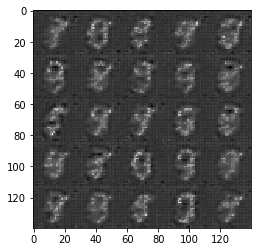

Epoch 10/10... Batch 4610... Discriminator Loss: 0.0933... Generator Loss: 5.0049
Epoch 10/10... Batch 4620... Discriminator Loss: 0.0927... Generator Loss: 4.7884
Epoch 10/10... Batch 4630... Discriminator Loss: 0.1230... Generator Loss: 4.1320
Epoch 10/10... Batch 4640... Discriminator Loss: 0.0628... Generator Loss: 4.9166
Epoch 10/10... Batch 4650... Discriminator Loss: 0.1009... Generator Loss: 4.3301
Epoch 10/10... Batch 4660... Discriminator Loss: 0.3609... Generator Loss: 3.2996
Epoch 10/10... Batch 4670... Discriminator Loss: 0.0577... Generator Loss: 5.7269
Epoch 10/10... Batch 4680... Discriminator Loss: 4.0415... Generator Loss: 12.7456


In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.01

epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 100... Discriminator Loss: 0.0000... Generator Loss: 25.5647
Epoch 1/1... Batch 200... Discriminator Loss: 0.0247... Generator Loss: 16.6457
Epoch 1/1... Batch 300... Discriminator Loss: 0.0000... Generator Loss: 75.8251
Epoch 1/1... Batch 400... Discriminator Loss: 0.0000... Generator Loss: 91.6233
Epoch 1/1... Batch 500... Discriminator Loss: 0.0000... Generator Loss: 60.8075


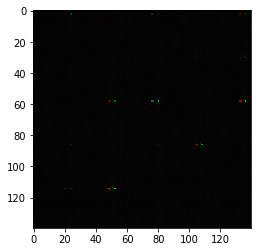

Epoch 1/1... Batch 600... Discriminator Loss: 0.0017... Generator Loss: 13.6057
Epoch 1/1... Batch 700... Discriminator Loss: 0.0000... Generator Loss: 14.6301
Epoch 1/1... Batch 800... Discriminator Loss: 0.0000... Generator Loss: 34.5671
Epoch 1/1... Batch 900... Discriminator Loss: 0.0000... Generator Loss: 41.3051
Epoch 1/1... Batch 1000... Discriminator Loss: 0.0000... Generator Loss: 105.5353


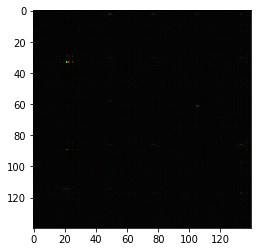

Epoch 1/1... Batch 1100... Discriminator Loss: 0.0001... Generator Loss: 24.0144
Epoch 1/1... Batch 1200... Discriminator Loss: 0.0003... Generator Loss: 123.2841
Epoch 1/1... Batch 1300... Discriminator Loss: 0.0000... Generator Loss: 40.0701
Epoch 1/1... Batch 1400... Discriminator Loss: 0.0000... Generator Loss: 105.1273
Epoch 1/1... Batch 1500... Discriminator Loss: 0.0000... Generator Loss: 69.4378


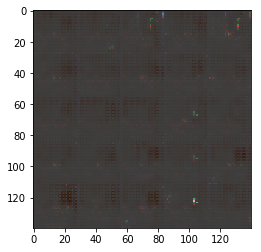

Epoch 1/1... Batch 1600... Discriminator Loss: 0.0000... Generator Loss: 420.8716
Epoch 1/1... Batch 1700... Discriminator Loss: 0.0038... Generator Loss: 446.9209
Epoch 1/1... Batch 1800... Discriminator Loss: 0.0000... Generator Loss: 305.1501
Epoch 1/1... Batch 1900... Discriminator Loss: 3.4279... Generator Loss: 238.0488
Epoch 1/1... Batch 2000... Discriminator Loss: 0.0000... Generator Loss: 665.9280


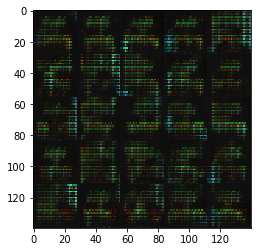

Epoch 1/1... Batch 2100... Discriminator Loss: 0.0000... Generator Loss: 238.6374
Epoch 1/1... Batch 2200... Discriminator Loss: 0.0000... Generator Loss: 230.7230
Epoch 1/1... Batch 2300... Discriminator Loss: 0.0000... Generator Loss: 147.9259
Epoch 1/1... Batch 2400... Discriminator Loss: 0.0000... Generator Loss: 195.5874
Epoch 1/1... Batch 2500... Discriminator Loss: 0.0001... Generator Loss: 132.6062


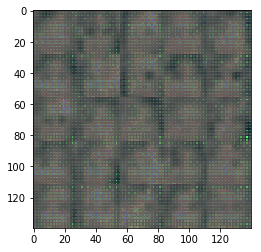

Epoch 1/1... Batch 2600... Discriminator Loss: 0.0000... Generator Loss: 36.5638
Epoch 1/1... Batch 2700... Discriminator Loss: 0.0029... Generator Loss: 53.9990
Epoch 1/1... Batch 2800... Discriminator Loss: 0.0001... Generator Loss: 25.1071
Epoch 1/1... Batch 2900... Discriminator Loss: 0.0053... Generator Loss: 17.5084
Epoch 1/1... Batch 3000... Discriminator Loss: 0.0021... Generator Loss: 12.8061


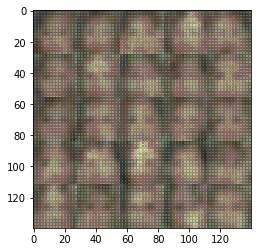

Epoch 1/1... Batch 3100... Discriminator Loss: 0.0404... Generator Loss: 9.9502


In [79]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.01

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.